# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорты

In [1]:
# !pip install optuna -q
# !pip install wordcloud -q
# !pip install --upgrade Pillow -q
# !pip install vaderSentiment -q

In [2]:
# Стандартная библиотека
import logging
import warnings
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from matplotlib import font_manager

# Научные и аналитические библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Работа с текстом
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords as nltk_stopwords
from nltk import pos_tag
from nltk.tokenize import TreebankWordTokenizer  # <-- используем его вместо word_tokenize

# Оптимизация гиперпараметров
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Прогресс
from tqdm import tqdm
tqdm.pandas()

# Логирование
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

# --- локальный путь для NLTK ---
nltk_data_dir = './nltk_data'
os.makedirs(nltk_data_dir, exist_ok=True)
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)

# --- загрузка NLTK ресурсов (совместимо с новыми версиями) ---
nltk_packages = [
    "punkt",
    "wordnet",
    "omw-1.4",
    "stopwords",
    "averaged_perceptron_tagger_eng",
    "averaged_perceptron_tagger"
]

for pkg in nltk_packages:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg, download_dir=nltk_data_dir, quiet=False)

e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ./nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     ./nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ./nltk_data...
[nltk_dat

### Константы

In [3]:
CV = 3
N_OPTUNA = 5
TEST_SIZE = 0.2
RANDOM_STATE = 20

In [4]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])
# df = pd.read_csv('./data/toxic_comments.csv', index_col=[0])
display(df.head())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


2026-01-13 11:13:44 [INFO] __main__: Распределение классов:
toxic
0    143106
1     16186
Name: count, dtype: int64
2026-01-13 11:13:44 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-13 11:13:44 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


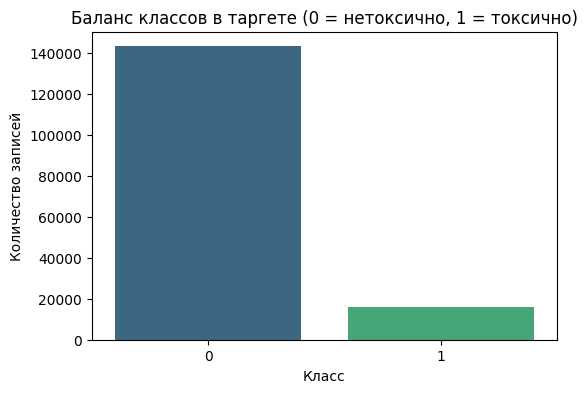

In [5]:
# Баланс классов
class_counts = df['toxic'].value_counts()
logger.info(f"Распределение классов:\n{class_counts}")

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Баланс классов в таргете (0 = нетоксично, 1 = токсично)")
plt.ylabel("Количество записей")
plt.xlabel("Класс")
plt.show()


In [6]:
def normalize_text(text: str) -> str:
    """
    Общая нормализация текста:
    - lowercase
    - удаление ссылок
    - только a-z
    - удаление одиночных букв
    - нормализация пробелов
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\b[a-z]\b", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

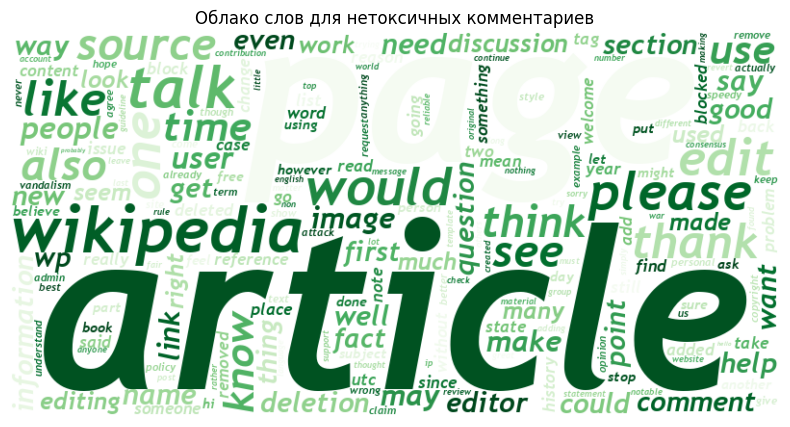

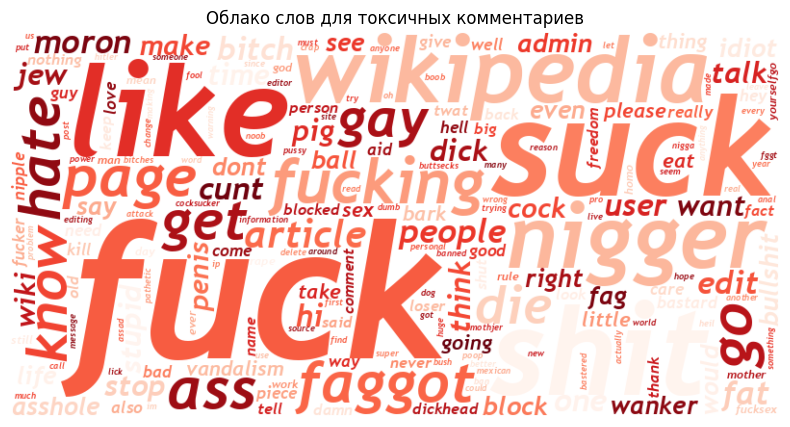

In [7]:
# английские стоп-слова
stopwords_en = set(nltk_stopwords.words("english"))

font_paths = font_manager.findSystemFonts(fontext='ttf')
if not font_paths:
    raise RuntimeError("Не найдено ни одного TTF-шрифта в системе")
font_path = font_paths[0]

for label, cmap in zip([0, 1], ["Greens", "Reds"]):
    texts = df.loc[df["toxic"] == label, "text"].dropna().astype(str)
    
    clean_texts = [
        normalize_text(t) for t in texts
        if normalize_text(t)
    ]

    if not clean_texts:
        continue

    text = " ".join(clean_texts)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=stopwords_en,
        colormap=cmap,
        max_words=200,
        font_path=font_path,
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(np.array(wordcloud.to_image()), interpolation="bilinear")
    plt.axis("off")
    plt.title(
        f"Облако слов для {'токсичных' if label == 1 else 'нетоксичных'} комментариев"
    )
    plt.show()


Здесь мы видим, что в токсичных твитах наиболее часто встречается слово fuck

toxic                           0             1
word_count   count  102539.000000  13714.000000
             mean       41.753664     32.581887
             std        32.780366     29.868323
             min         2.000000      1.000000
             25%        17.000000     11.000000
             50%        32.000000     22.000000
             75%        58.000000     43.000000
             max       152.000000    152.000000
avg_word_len count  102539.000000  13714.000000
             mean        4.603059      4.410644
             std         0.535666      0.587450
             min         1.312500      1.000000
             25%         4.259259      4.031250
             50%         4.617647      4.413793
             75%         4.983871      4.808438
             max         5.722222      5.722222
sentiment    count  102539.000000  13714.000000
             mean        0.066141     -0.435311
             std         0.477542      0.489785
             min        -0.999700     -1.000000
             25%        -0.273200     -0.834675
             50%         0.000000     -0.585900
             75%         0.458800     -0.034300
             max         0.830200      0.830000

2026-01-13 11:15:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-13 11:15:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-13 11:15:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-13 11:15:05 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-13 11:15:05 [INFO] matplotlib.category: 

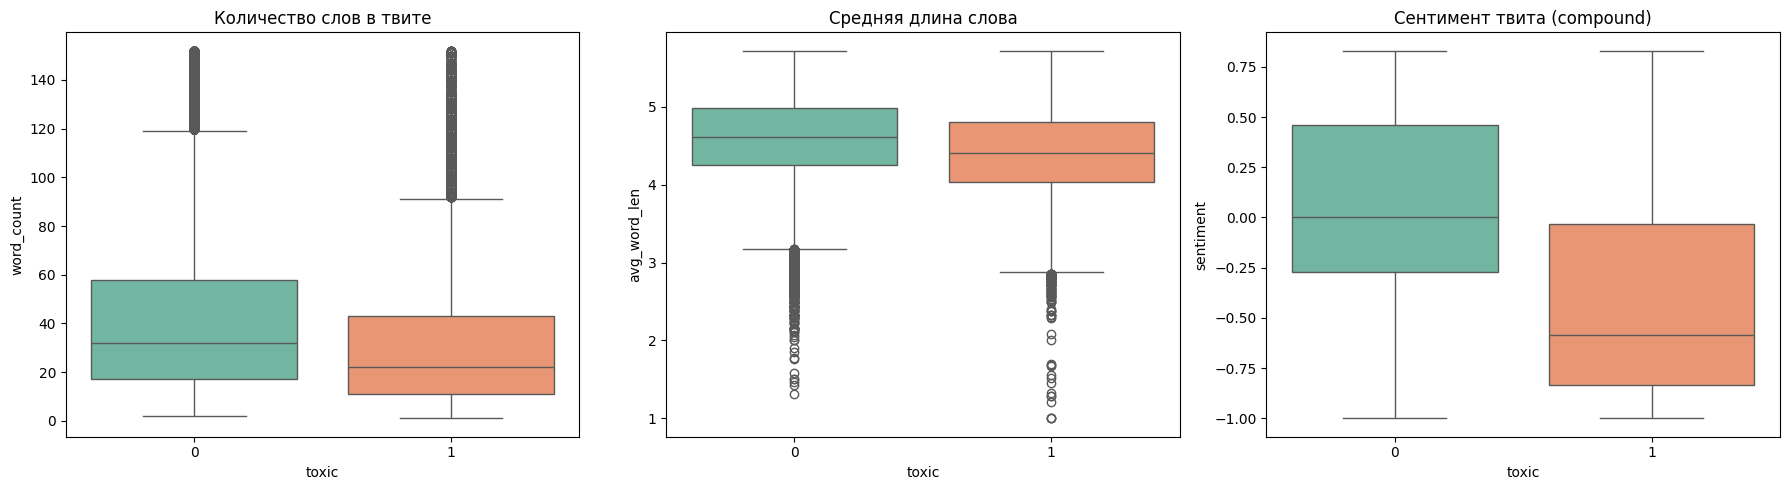

In [8]:
# создаем анализатор сентиментов
analyzer = SentimentIntensityAnalyzer()

# подсчет признаков
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['avg_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# фильтруем выбросы выше 90-го перцентиля
for col in ['word_count', 'avg_word_len', 'sentiment']:
    threshold = df[col].quantile(0.9)
    df = df[df[col] <= threshold]

# агрегируем по таргету
agg_df = df.groupby('toxic')[['word_count', 'avg_word_len', 'sentiment']].describe().T
display(agg_df)

# визуализация
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(x='toxic', y='word_count', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Количество слов в твите')

sns.boxplot(x='toxic', y='avg_word_len', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Средняя длина слова')

sns.boxplot(x='toxic', y='sentiment', data=df, ax=axes[2], palette='Set2')
axes[2].set_title('Сентимент твита (compound)')

plt.tight_layout()
plt.show()


Что касается признаков:  
1) Число слов - токсичные твиты немного короче  
2) Средняя длина слов - слова также короче  
3) Эмоциональная окраска - сентименты тоже отработали достаточно точно  

### Подготовка текста

In [9]:
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()
stopwords_en = set(nltk_stopwords.words("english"))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    if treebank_tag.startswith("V"):
        return wordnet.VERB
    if treebank_tag.startswith("N"):
        return wordnet.NOUN
    if treebank_tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

def tfidf_clean_lemmatize(text: str) -> str:
    """
    normalize_text + токенизация + POS + лемматизация + stopwords
    """
    text = normalize_text(text)
    if not text:
        return ""

    tokens = tokenizer.tokenize(text)
    pos_tags = pos_tag(tokens)

    lemmas = [
        lemmatizer.lemmatize(token, get_wordnet_pos(pos))
        for token, pos in pos_tags
        if token not in stopwords_en
    ]

    return " ".join(lemmas)


# проверим на тестах
test_sentences = [
    "The striped bats are hanging on their feet for best",
    "you should be ashamed of yourself went worked",
    "cars were running faster than buses",
]

df_test = pd.DataFrame({"text": test_sentences})
df_test["text_clean"] = df_test["text"].apply(tfidf_clean_lemmatize)
display(df_test)

,text,text_clean
0,The striped bats are hanging on their feet for...,striped bat hang foot best
1,you should be ashamed of yourself went worked,ashamed go work
2,cars were running faster than buses,car run faster bus


In [10]:
# прогоним всю базу
df["text_clean"] = df["text"].progress_apply(tfidf_clean_lemmatize)

100%|██████████| 116253/116253 [02:16<00:00, 850.96it/s]


In [11]:
display(df.sample(5))

,text,toxic,word_count,avg_word_len,sentiment,text_clean
132730,"Scat & BDSM \n\nHi, I was wondering if faggots...",1,25,4.480000,-0.6369,scat bdsm hi wonder faggot large participate s...
20221,"""\n\n There are now two meaningful and mater...",0,143,4.419580,-0.7088,two meaningful material article usaas love usa...
89889,"18:16, 16 October 2006",0,4,4.750000,0.0000,october
109736,"""\n\nRugby\nBy any chance, are you from Fiji, ...",0,21,3.904762,0.2500,rugby chance fiji seem know lot fiji rugby pla...
80657,I added the proper sources to my updates. I j...,0,47,4.468085,0.3818,add proper source update want take time note e...


In [12]:
TEXT_COL = "text_clean"
NUM_COLS = ["word_count", "avg_word_len", "sentiment"]
TARGET_COL = "toxic"

df_train, df_test = train_test_split(
    df[[TEXT_COL] + NUM_COLS + [TARGET_COL]],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[TARGET_COL],
)

X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]

logger.info(f"Train size: {len(df_train)}, Test size: {len(df_test)}")

2026-01-13 11:17:24 [INFO] __main__: Train size: 93002, Test size: 23251


In [13]:
text_transformer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    max_features=100_000,
    stop_words="english",
    sublinear_tf=True,
    norm="l2",
)

numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, TEXT_COL),
        ("num", numeric_transformer, NUM_COLS),
    ],
    remainder="drop",
    n_jobs=-1,
)


## Обучение

In [ ]:
best_models = {}
models_to_run = ["LogisticRegression", "RidgeClassifier", "RandomForestClassifier"]

for model_name in models_to_run:

    logger.info(f"===== START MODEL: {model_name} =====")

    def objective(trial):

        if model_name == "LogisticRegression":
            model = LogisticRegression(
                C=trial.suggest_float("C", 1e-3, 10.0, log=True),
                max_iter=2000,
                class_weight="balanced",
                n_jobs=-1,
                solver="lbfgs",
                random_state=RANDOM_STATE,
            )

        elif model_name == "RidgeClassifier":
            model = RidgeClassifier(
                alpha=trial.suggest_float("alpha", 1e-3, 10.0, log=True),
                class_weight="balanced",
                random_state=RANDOM_STATE,
            )
        
        else:  # RandomForestClassifier
            model = RandomForestClassifier(
                n_estimators=trial.suggest_int("n_estimators", 100, 500),
                max_depth=trial.suggest_int("max_depth", 2, 10),
                min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
                min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
                max_features=trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
                class_weight="balanced",
                n_jobs=-1,
                random_state=RANDOM_STATE,
            )

        pipe = Pipeline(
            steps=[
                ("preprocess", preprocessor),
                ("model", model),
            ]
        )

        cv = StratifiedKFold(
            n_splits=CV,
            shuffle=True,
            random_state=RANDOM_STATE,
        )

        scores = cross_val_score(
            pipe,
            X_train,
            y_train,
            cv=cv,
            scoring='f1',
            n_jobs=-1,
            error_score='raise'
        )

        mean_score = float(np.mean(scores))
        
        # Для pruning можно использовать промежуточные результаты
        # Optuna не поддерживает pruning с cross_val_score напрямую,
        # поэтому просто сообщаем промежуточный результат
        for i, score in enumerate(scores):
            trial.report(score, i)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return mean_score

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=RANDOM_STATE),
        pruner=MedianPruner(
            n_startup_trials=2,
            n_warmup_steps=1,
        ),
    )

    study.optimize(objective, n_trials=N_OPTUNA, show_progress_bar=False)

    best_models[model_name] = {
        'trial': study.best_trial,
        'study': study
    }

    logger.info(
        f"[{model_name}] Best F1={study.best_value:.4f} "
        f"(std={study.best_trial.user_attrs.get('cv_std', 0):.4f})"
    )

2026-01-13 11:17:24 [INFO] __main__: ===== START MODEL: LogisticRegression =====
2026-01-13 11:18:03 [INFO] __main__: [LogisticRegression] Best F1=0.7756 (std=0.0000)
2026-01-13 11:18:03 [INFO] __main__: ===== START MODEL: RidgeClassifier =====
2026-01-13 11:18:35 [INFO] __main__: [RidgeClassifier] Best F1=0.7376 (std=0.0000)
2026-01-13 11:18:35 [INFO] __main__: ===== START MODEL: RandomForestClassifier =====
2026-01-13 11:26:06 [INFO] __main__: [RandomForestClassifier] Best F1=0.5440 (std=0.0000)


In [ ]:
best_model_name = max(
    best_models,
    key=lambda k: best_models[k]['trial'].value
)

best_trial = best_models[best_model_name]['trial']
params = best_trial.params

if best_model_name == "LogisticRegression":
    final_model = LogisticRegression(
        **params,
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1,
        solver="lbfgs",
        random_state=RANDOM_STATE,
    )
elif best_model_name == "RidgeClassifier":
    final_model = RidgeClassifier(
        **params,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
else:
    final_model = RandomForestClassifier(
        **params,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    )

final_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", final_model),
    ]
)

final_pipe.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
test_cv_scores = cross_val_score(
    final_pipe, 
    X_test, 
    y_test, 
    cv=cv, 
    scoring='f1',
    n_jobs=-1
)

y_pred_test = final_pipe.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test)

logger.info(
    f"FINAL MODEL: {best_model_name} | "
    f"Test F1={test_f1:.4f} | "
    f"CV Test F1 mean={np.mean(test_cv_scores):.4f} (+-{np.std(test_cv_scores):.4f}) | "
    f"Params={params}"
)

2026-01-13 11:26:21 [INFO] __main__: FINAL MODEL: LogisticRegression | Test F1=0.7716 | CV Test F1 mean=0.7311 (+-0.0120) | Params={'C': 3.8981173727839376}


In [16]:
if best_model_name in ["LogisticRegression", "RidgeClassifier"]:
    model = final_pipe.named_steps["model"]
    preprocessor = final_pipe.named_steps["preprocess"]

    tfidf = preprocessor.named_transformers_["text"]

    feature_names = tfidf.get_feature_names_out()
    
    if best_model_name == "LogisticRegression":
        coefs = model.coef_[0]
    else:  # RidgeClassifier
        coefs = model.coef_[0]
    
    top_pos_idx = np.argsort(coefs)[-10:][::-1]

    top_toxic = pd.DataFrame({
        "feature": feature_names[top_pos_idx],
        "coef": coefs[top_pos_idx],
    })

    logger.info(f"Top toxic features for {best_model_name}:")
    display(top_toxic)
else:
    logger.info("Feature importance analysis for RandomForestClassifier:")
    
    model = final_pipe.named_steps["model"]
    preprocessor = final_pipe.named_steps["preprocess"]
    
    tfidf = preprocessor.named_transformers_["text"]
    feature_names = tfidf.get_feature_names_out()
    
    # Получаем важность признаков из Random Forest
    importances = model.feature_importances_
    top_important_idx = np.argsort(importances)[-10:][::-1]
    
    top_features = pd.DataFrame({
        "feature": feature_names[top_important_idx],
        "importance": importances[top_important_idx],
    })
    
    logger.info("Top 10 most important features (Random Forest):")
    display(top_features)

2026-01-13 11:26:21 [INFO] __main__: Top toxic features for LogisticRegression:


,feature,coef
0,fuck,33.640130
1,shit,21.340762
2,idiot,21.317570
3,stupid,18.562982
4,asshole,17.858482
5,suck,16.903445
6,bullshit,14.885466
7,bitch,14.822499
8,dick,14.454207
9,moron,14.267379


In [17]:
if best_model_name in ["LogisticRegression", "RidgeClassifier"]:
    top_neg_idx = np.argsort(coefs)[:10]

    top_clean = pd.DataFrame({
        "feature": feature_names[top_neg_idx],
        "coef": coefs[top_neg_idx],
    })

    logger.info(f"Top clean (non-toxic) features for {best_model_name}:")
    display(top_clean)

2026-01-13 11:26:21 [INFO] __main__: Top clean (non-toxic) features for LogisticRegression:


,feature,coef
0,mention,-4.719507
1,section,-4.703916
2,review,-4.506359
3,accord,-4.501542
4,talk,-4.457347
5,lead,-4.272720
6,sorry,-4.236850
7,title,-4.213882
8,source,-4.115753
9,stop continue,-4.021431


## Выводы

### Выводы по результатам эксперимента

#### Выполненные шаги

1. **Предобработка текста**
   - Приведение текста к нижнему регистру.
   - Удаление ссылок, спецсимволов, одиночных букв.
   - Очистка пробелов и стоп-слов.

2. **Преобразование текста в числовой формат**
   - Построение TF-IDF признаков с учётом униграмм и биграмм.
   - Ограничение по минимальной и максимальной частоте слов.
   - Нормализация L2 и сублинейная TF.

3. **Разделение выборки**
   - Train / Test split с стратификацией по целевому классу.
   - Сброс индексов для удобства работы.

4. **Подбор модели**
   - Оптимизация гиперпараметров LogisticRegression и RidgeClassifier через Optuna с кросс-валидацией.
   - Обучение на всей тренировочной выборке после подбора лучших параметров.

5. **Оценка результатов**
   - F1-score на тестовой выборке.
   - Проверка баланса классов.
   - Контроль утечек данных и согласованности действий.

#### Результаты

1. **Качество моделей**
- `LogisticRegression + TF-IDF` показала лучший результат:
  - CV F1 ~ 0.7749
  - Test F1 ~ 0.7684
- `RidgeClassifier` слабее:
  - CV F1 ~ 0.7318

2. **Обобщающая способность**
- Разница между CV и тестом минимальна переобучения нет.
- TF-IDF обучался только на train утечек данных нет.

3. **Оптимальность архитектуры**
- Для токсик-классификации TF-IDF + линейная модель достаточно:
  - захватывает лексику и n-граммы
  - нелинейность не критична

4. **LGBM / XGBoost**
- Эти модели могут дать чуть более высокий F1,  
  но обучение дольше и требует больше памяти.
- Прирост качества не оправдывает дополнительные ресурсы.

5. **Практический итог**
- Простые модели:
  - быстро обучаются
  - легко деплоятся
  - проще интерпретируются
  - стабильны в продакшене
- Качество уже близко к «потолку» для классического NLP без нейросетей.

**Итог:** проделанные действия позволили перейти с BERT на TF-IDF + LogisticRegression, что дало высокое качество, ускорило обучение, упростило код и инфраструктуру, устранив лишние вычислительные затраты.